<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=141293617" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
from spx_strategies import *
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
purchase_time = '16:00:00'
# In dollars
commission = 1.5

load_cboe = False
load_tradier = True



Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-12-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-08-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-18-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-22-22.db
Copying db file to output : optim

In [2]:
if load_cboe:

    files = [
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
    #    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
        #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
     #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
      #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
      # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
       f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
    ]
    li = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    # Warning : changning initial portfolio value will invalidate all prior studies
    initial_portfolio_value = df.loc[1,'price']*20

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [3]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
                initial_portfolio_value = df.loc[1,'price']*20
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)




In [4]:
df[(df['expiration']=='2023-08-18')&(df['quote_time']=='09:31:00')&(df['strike']==4400)]

,bid,ask,strike,expiration,price,iv,delta,type,quote_time,quote_date,dte
7573378,27.10,28.10,4400.0,2023-08-18,4404.33,0.241884,0.535437,C,09:31:00,2023-08-17,1
7573379,6.20,6.60,4400.0,2023-08-18,4404.33,0.083896,0.405804,P,09:31:00,2023-08-17,1
7573380,31.00,31.40,4400.0,2023-08-18,4404.33,0.276170,0.531801,C,09:31:00,2023-08-17,1
7573381,10.00,10.20,4400.0,2023-08-18,4404.33,0.120522,0.433390,P,09:31:00,2023-08-17,1
8303498,0.00,6.50,4400.0,2023-08-18,4370.36,0.293341,0.200905,C,09:31:00,2023-08-18,0
8303499,20.60,49.40,4400.0,2023-08-18,4370.36,0.253820,0.834001,P,09:31:00,2023-08-18,0
8303500,0.45,0.55,4400.0,2023-08-18,4370.36,0.160348,0.061917,C,09:31:00,2023-08-18,0
8303501,57.40,58.10,4400.0,2023-08-18,4370.36,0.867753,0.607560,P,09:31:00,2023-08-18,0


In [5]:
df[(df['expiration']=='2023-07-21')&(df['quote_time']=='16:01:00')&(df['strike']==4530)]

,bid,ask,strike,expiration,price,iv,delta,type,quote_time,quote_date,dte
1739388,11.8,12.60,4530.0,2023-07-21,4532.72,0.111150,0.552044,C,16:01:00,2023-07-20,1
1739389,3.9,4.20,4530.0,2023-07-21,4532.72,0.058621,0.403585,P,16:01:00,2023-07-20,1
1739390,15.5,15.80,4530.0,2023-07-21,4532.72,0.147333,0.539970,C,16:01:00,2023-07-20,1
1739391,7.4,7.50,4530.0,2023-07-21,4532.72,0.095452,0.439809,P,16:01:00,2023-07-20,1
2456200,6.2,20.30,4530.0,2023-07-21,4537.79,0.000200,0.000000,C,16:01:00,2023-07-21,0
2456201,3.4,4.20,4530.0,2023-07-21,4537.79,0.000200,0.000000,P,16:01:00,2023-07-21,0
2456202,5.1,8.10,4530.0,2023-07-21,4537.79,NaN,0.000000,C,16:01:00,2023-07-21,0
2456203,0.0,0.05,4530.0,2023-07-21,4537.79,0.000200,0.000000,P,16:01:00,2023-07-21,0


# Backtest Optimization

In [6]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [7]:
# Study Configuration
op_sel = DeltaOptionSelector
ent_pol_config = OptionSelectorStaticEntryPolicy
study_param_ranges = {
    'sp':(0.005,0.45),
    'lp':(0.002,'sp_trial'),
    'sc':(0.005,0.45),
    'lc':(0.002,'sc_trial'),
}
misc_configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return']

In [9]:
list(study_param_ranges.values())[0][0]

0.005

In [10]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float(list(study_param_ranges.keys())[0], list(study_param_ranges.values())[0][0], list(study_param_ranges.values())[0][1])
    delta_lp_trial = trial.suggest_float(list(study_param_ranges.keys())[1], list(study_param_ranges.values())[1][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float(list(study_param_ranges.keys())[2], list(study_param_ranges.values())[2][0], list(study_param_ranges.values())[2][1])
    delta_lc_trial = trial.suggest_float(list(study_param_ranges.keys())[3], list(study_param_ranges.values())[3][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_config(misc_configs_ent_pol['dte'], misc_configs_ent_pol['pt'], dos)
    ex_pol = HoldToExpStaticExitPolicy('16:00:00')

    strategy = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [11]:
def type_to_str(input_type):
    ent_pol_type = str(type(input_type))
    i_start = ent_pol_type.index('spx_strategies')
    return ent_pol_type[23:-2]

In [12]:
new_study_name = op_sel.__name__ + '_' + ent_pol_config.__name__

# concatenate ranges first
for k,v in study_param_ranges.items():
    new_study_name+="|"+k+":"+str(v[0])+"-"+str(v[1])
    
# concatenate static values second
for k,v in misc_configs_ent_pol.items():
    new_study_name += f"|{k}:{v}"
    
print(new_study_name)

DeltaOptionSelector_OptionSelectorStaticEntryPolicy|sp:0.005-0.45|lp:0.002-sp_trial|sc:0.005-0.45|lc:0.002-sc_trial|dte:1|pt:16:00:00


In [13]:
print("entPol_1|os_1|valRange_9843")

entPol_1|os_1|valRange_9843


In [14]:
new_study_name = op_sel.__name__ + '_' + ent_pol_config.__name__

# concatenate ranges first
for k,v in study_param_ranges.items():
    new_study_name+="|"+k+":"+str(v[0])+"-"+str(v[1])
    
# concatenate static values second
for k,v in misc_configs_ent_pol.items():
    new_study_name += f"|{k}:{v}"
    
print(new_study_name)

study_name = new_study_name  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 10)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

DeltaOptionSelector_OptionSelectorStaticEntryPolicy|sp:0.005-0.45|lp:0.002-sp_trial|sc:0.005-0.45|lc:0.002-sc_trial|dte:1|pt:16:00:00


[I 2023-08-28 22:43:11,734] A new study created in RDB with name: DeltaOptionSelector_OptionSelectorStaticEntryPolicy|sp:0.005-0.45|lp:0.002-sp_trial|sc:0.005-0.45|lc:0.002-sc_trial|dte:1|pt:16:00:00
[I 2023-08-28 22:43:19,340] Trial 0 finished with value: 0.94 and parameters: {'sp': 0.38544244886128576, 'lp': 0.3049880357133265, 'sc': 0.06961839876888999, 'lc': 0.0692404006454373}. Best is trial 0 with value: 0.94.
[I 2023-08-28 22:43:26,899] Trial 1 finished with value: 1.097 and parameters: {'sp': 0.2697232333583452, 'lp': 0.2165287088081881, 'sc': 0.24942738399064532, 'lc': 0.06582554570638177}. Best is trial 1 with value: 1.097.
[I 2023-08-28 22:43:34,426] Trial 2 finished with value: 0.965 and parameters: {'sp': 0.43540975585981856, 'lp': 0.25905330659412185, 'sc': 0.0756872863577874, 'lc': 0.05658200297465605}. Best is trial 1 with value: 1.097.
[I 2023-08-28 22:43:42,202] Trial 3 finished with value: 1.008 and parameters: {'sp': 0.17190457499595457, 'lp': 0.11903777921131144, '

Best Score:  1.14
Best Params: 
  lc: 0.20190680999564128
  lp: 0.2560376543291092
  sc: 0.38863973971127447
  sp: 0.32502959580534807


# Backtest with current best score

*****  BACKTEST RESULTS  ****
Cumulative Return                                  1.14
Max Drawdown                                     -2.216
Mean Net Max Loss                              1008.468
Max Net Max Loss                                 1645.0
Mean Return on Max Risk                           0.236
Std Dev of Return on Max Risk                     1.676
Risk Adj Cumulative Return On Scaled Max Risk      0.68
Trading Days                                         31
Wins                                                 18
Losses                                               13
Breakeven                                             0
Win/Loss Ratio                                   58.065
Mean Win                                        494.167
Mean Loss                                      -648.654
Mean Net Trans                                   14.919
Std Dev of Net Trans                            651.579
Max Loss                                        -1243.5
Max Win           

,trade_date,expiration,trade_count,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,0.32503,4490.0,0.286450,467.5,0.38864,4515.0,0.346514,600.0,0.201907,4530.0,0.165769,-230.0,0.256038,4485.0,0.223157,-337.5,500.0,1169.0,0.0,4526.69,6.0,1169.0,-675.0,89525.8,-675.0,NaN,-0.007483,0.000207,1500.0,1000.0,-0.675000,0.986500
1,2023-07-17,2023-07-18,4.0,0.32503,4510.0,0.269545,467.5,0.38864,4535.0,0.351153,467.5,0.201907,4550.0,0.147009,-165.0,0.256038,4505.0,0.212205,-340.0,430.0,1500.0,0.0,4558.32,6.0,1500.0,-1076.0,88449.8,-1751.0,-0.012019,-0.019412,0.000208,1500.0,1070.0,-1.005607,0.979888
2,2023-07-18,2023-07-19,4.0,0.32503,4545.0,0.304246,535.0,0.38864,4570.0,0.313604,452.5,0.201907,4580.0,0.185865,-240.0,0.256038,4540.0,0.246720,-412.5,335.0,0.0,0.0,4568.48,6.0,0.0,329.0,88778.8,-1422.0,0.003720,-0.015765,0.000208,1000.0,665.0,0.494737,1.009895
3,2023-07-19,2023-07-20,4.0,0.32503,4555.0,0.311034,577.5,0.38864,4580.0,0.357224,710.0,0.201907,4595.0,0.192951,-317.5,0.256038,4545.0,0.215388,-380.0,590.0,0.0,1000.0,4534.01,6.0,1000.0,-416.0,88362.8,-1838.0,-0.004686,-0.020377,0.000208,1500.0,910.0,-0.457143,0.990857
4,2023-07-20,2023-07-21,4.0,0.32503,4520.0,0.288242,477.5,0.38864,4545.0,0.369584,775.0,0.201907,4560.0,0.199779,-330.0,0.256038,4515.0,0.232435,-370.0,552.5,0.0,0.0,4537.79,6.0,0.0,546.5,88909.3,-1291.5,0.006185,-0.014318,0.000208,1500.0,947.5,0.576781,1.011536
5,2023-07-21,2023-07-24,4.0,0.32503,4525.0,0.304814,567.5,0.38864,4550.0,0.335813,527.5,0.201907,4560.0,0.195514,-255.0,0.256038,4520.0,0.244659,-422.5,417.5,282.0,0.0,4552.82,6.0,282.0,129.5,89038.8,-1162.0,0.001457,-0.012882,0.000208,1000.0,582.5,0.222318,1.004446
6,2023-07-24,2023-07-25,4.0,0.32503,4540.0,0.279923,405.0,0.38864,4565.0,0.333312,577.5,0.201907,4580.0,0.153547,-207.5,0.256038,4535.0,0.219890,-305.0,470.0,638.0,0.0,4571.38,6.0,638.0,-174.0,88864.8,-1336.0,-0.001954,-0.014811,0.000208,1500.0,1030.0,-0.168932,0.996621
7,2023-07-25,2023-07-26,4.0,0.32503,4550.0,0.322377,1025.0,0.38864,4585.0,0.380224,1100.0,0.201907,4610.0,0.183649,-415.0,0.256038,4540.0,0.251065,-730.0,980.0,0.0,0.0,4566.59,6.0,0.0,974.0,89838.8,-362.0,0.010960,-0.004013,0.000209,2500.0,1520.0,0.640789,1.012816
8,2023-07-26,2023-07-27,4.0,0.32503,4555.0,0.315993,527.5,0.38864,4580.0,0.339728,685.0,0.201907,4595.0,0.176236,-280.0,0.256038,4545.0,0.206228,-320.0,612.5,0.0,1000.0,4533.77,6.0,1000.0,-393.5,89445.3,-755.5,-0.004380,-0.008376,0.000209,1500.0,887.5,-0.443380,0.991132
9,2023-07-27,2023-07-28,4.0,0.32503,4515.0,0.304406,750.0,0.38864,4550.0,0.355416,990.0,0.201907,4570.0,0.190843,-422.5,0.256038,4505.0,0.232562,-555.0,762.5,2000.0,0.0,4578.72,6.0,2000.0,-1243.5,88201.8,-1999.0,-0.013902,-0.022162,0.000209,2000.0,1237.5,-1.004848,0.979903


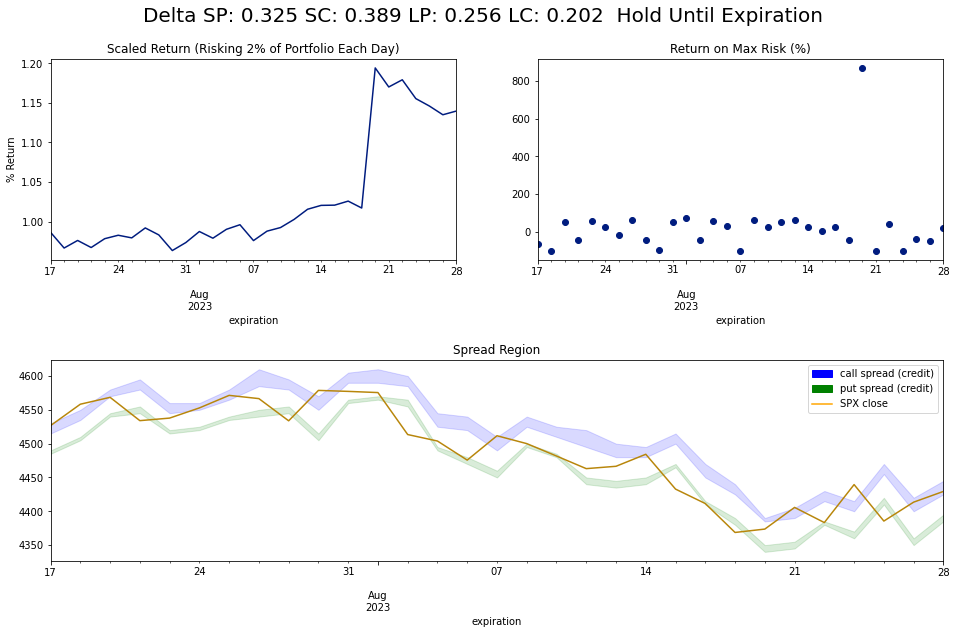

In [15]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
ex_pol = HoldToExpStaticExitPolicy('16:00:00')
strat = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

*****  BACKTEST RESULTS  ****
Cumulative Return                                 0.859
Max Drawdown                                     -2.882
Mean Win Trans Return                               1.1
Mean Loss Trans Return                            -1.77
Mean Trans Return                                 0.047
Std Dev of Trans Return                           0.017
Sharpe Ratio static STD                           0.244
Sharpe Ratio with RF STD                          0.244
Risk Adj Cumulative Return                       49.653
Dampened Risk Adj Cumulative Return               6.529
Trading Days                                         31
Wins                                                 19
Losses                                               12
Breakeven                                             0
Win/Loss Ratio                                    61.29
Mean Win                                          996.5
Mean Loss                                      -1513.25
Mean Net Trans    

,trade_date,expiration,trade_count,yield_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,yield_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,short_long_balance_call,short_long_balance_put
0,2023-07-14,2023-07-17,2.0,0.01,4505.0,0.503940,1025.0,0.01,4505.0,0.496281,1030.0,2055.0,2169.0,0.0,4526.69,3.0,2169.0,-117.0,90083.8,-117.0,NaN,-0.001297,0.000207,-1.0,-1.0
1,2023-07-17,2023-07-18,2.0,0.01,4520.0,0.401656,860.0,0.01,4525.0,0.551838,850.0,1710.0,3332.0,0.0,4558.32,3.0,3332.0,-1625.0,88458.8,-1742.0,-0.018039,-0.019312,0.000208,-1.0,-1.0
2,2023-07-18,2023-07-19,2.0,0.01,4555.0,0.443344,950.0,0.01,4555.0,0.576088,1050.0,2000.0,1348.0,0.0,4568.48,3.0,1348.0,649.0,89107.8,-1093.0,0.007337,-0.012117,0.000208,-1.0,-1.0
3,2023-07-19,2023-07-20,2.0,0.01,4565.0,0.440975,940.0,0.01,4575.0,0.418772,855.0,1795.0,0.0,3099.0,4534.01,3.0,3099.0,-1307.0,87800.8,-2400.0,-0.014668,-0.026607,0.000208,-1.0,-1.0
4,2023-07-20,2023-07-21,2.0,0.01,4540.0,0.651749,860.0,0.01,4535.0,0.494829,855.0,1715.0,279.0,221.0,4537.79,3.0,500.0,1212.0,89012.8,-1188.0,0.013804,-0.013171,0.000208,-1.0,-1.0
5,2023-07-21,2023-07-24,2.0,0.01,4535.0,0.437252,1005.0,0.01,4540.0,0.496859,942.5,1947.5,1282.0,0.0,4552.82,3.0,1282.0,662.5,89675.3,-525.5,0.007443,-0.005826,0.000208,-1.0,-1.0
6,2023-07-24,2023-07-25,2.0,0.01,4555.0,0.527620,930.0,0.01,4555.0,0.479411,1035.0,1965.0,1638.0,0.0,4571.38,3.0,1638.0,324.0,89999.3,-201.5,0.003613,-0.002234,0.000208,-1.0,-1.0
7,2023-07-25,2023-07-26,2.0,0.01,4550.0,0.322377,1025.0,0.01,4590.0,0.337122,935.0,1960.0,0.0,0.0,4566.59,3.0,0.0,1957.0,91956.3,1755.5,0.021745,0.019462,0.000209,-1.0,-1.0
8,2023-07-26,2023-07-27,2.0,0.01,4565.0,0.461741,855.0,0.01,4575.0,0.403442,892.5,1747.5,0.0,3123.0,4533.77,3.0,3123.0,-1378.5,90577.8,377.0,-0.014991,0.004180,0.000209,-1.0,-1.0
9,2023-07-27,2023-07-28,2.0,0.01,4525.0,0.397876,1055.0,0.01,4550.0,0.355416,990.0,2045.0,2872.0,0.0,4578.72,3.0,2872.0,-830.0,89747.8,-453.0,-0.009163,-0.005022,0.000209,-1.0,-1.0


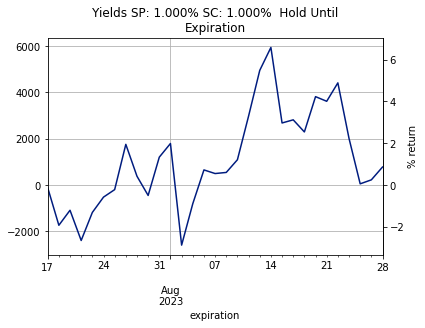

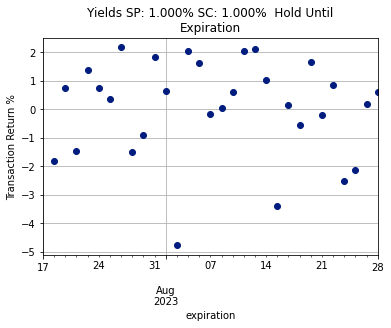

In [16]:
yos = YieldOptionSelector(short_puts=0.01, short_calls=0.01, ipv=initial_portfolio_value)
ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, yos)
ex_pol = HoldToExpStaticExitPolicy('16:00:00')
strat = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [17]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [18]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-28,2023-08-29,0.32503,4415.0,0.293893,517.5,0.38864,4440.0,0.386496,917.5,0.201907,4460.0,0.17465,-300.0,0.256038,4410.0,0.240887,-412.5,4,722.5


# Strikes following the 4/2 Strategy

In [19]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-28,2023-08-29,0.04,4370.0,0.038987,55.0,0.02,4495.0,0.016616,15.0,0.201907,4460.0,0.17465,-300.0,0.256038,4410.0,0.240887,-412.5,4,-642.5
